In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/privacy_permutation/')

Mounted at /content/drive


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

#from torchsummary import summary
%pip install torchinfo -q
from torchinfo import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import scipy.signal as signal

import utils

# %matplotlib widget
%matplotlib notebook
%matplotlib inline

<ipython-input-2-a9992df2c7b9>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
m = np.array([[1,2],[3,4]])
P = np.array([[0,1],[1,0]])


P @ m @ P.T

array([[4, 3],
       [2, 1]])

In [ ]:
# apply softmax to a random tensor

x = torch.randn(4,4)

soft_x = F.gumbel_softmax(x, hard=True)

print(soft_x), print(x)

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])
tensor([[-0.4884,  3.2561,  0.8783,  1.2068],
        [ 1.5633, -0.4647,  0.1635,  0.9188],
        [ 0.5430,  0.8639, -0.8693,  0.2083],
        [-0.5269, -1.0092, -0.5213,  0.8347]])


(None, None)

In [ ]:
# arnold transform

def arnold_transform(img, N):
    """
    Apply Arnold Transform to an image
    :param img: original image
    :param N: number of iterations
    :return: transformed image
    """
    img = np.array(img)
    img_ = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            I,J = (np.array([[1,1],[1,0]]) @ np.array([i,j]) ) % N
            img_[I,J] = img[i,j]


    return img_

#load lenna
lenna = plt.imread('lenna.png')
lenna = np.mean(lenna, axis=2)

#apply arnold transform

lenna_arnold = arnold_transform(lenna, 512)

#plot lenna and lenna_arnold

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(lenna)
ax[0].set_title('Original')
ax[1].imshow(lenna_arnold)
ax[1].set_title('Arnold Transform')



In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
utils.setup_seed(1312)

In [ ]:
img_size = 33

test = utils.Permutar(img_size, 1)
test.key.reshape(33,33)

array([[ 608,  275,  171, ...,  160,  829,  751],
       [ 543,  230,  739, ...,  541,  695,  156],
       [ 712,  539,   68, ...,  786,   64, 1007],
       ...,
       [ 902,  175,  855, ...,  808,  682,  526],
       [ 581, 1078,  409, ...,  388,  278,  237],
       [  90,   30,  375, ...,  791,  176,   81]])

In [ ]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform=transforms.Compose([
    T.Resize((33,33)),
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
    ])

trainset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform,)
testset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

fake_loader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False,drop_last=True)
a = list(fake_loader)
b = test.desordenar(a[0][0])

fake_loader2 = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False,drop_last=True)
a2 = list(fake_loader2)
b2 = test.desordenar(a2[0][0])

trainset_disorderly = torch.utils.data.TensorDataset(b,a[0][1])
testset_disorderly = torch.utils.data.TensorDataset(b2,a2[0][1])

train_loader = torch.utils.data.DataLoader(trainset_disorderly, batch_size=64, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset_disorderly, batch_size=64, shuffle=False, drop_last=True)

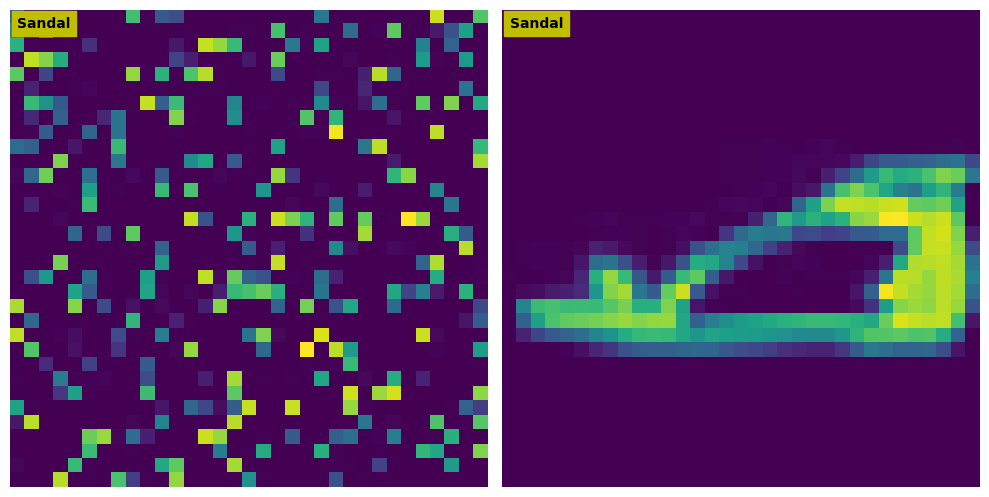

In [ ]:
a = next(iter(train_loader))
X,y = [a[0][0], a[1][0]]
fig,axs = plt.subplots(1,2,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  pic = X.data.cpu().numpy().transpose((1,2,0))
  if i == 1:
    pic = test.ordenar(X.unsqueeze(dim=0)).squeeze()
    pic = pic.data.cpu().numpy()

  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  label = testset.classes[y]



  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from permuted_newtork import PermutedNetwork_2, PermutedNetwork, NormalNetwork

model = NormalNetwork().to(device)

In [ ]:
summary(model, (1, 1, 33, 33))

Layer (type:depth-idx)                   Output Shape              Param #
NormalNetwork                            [1, 10]                   32
├─Conv2d: 1-1                            [1, 16, 33, 33]           160
├─MaxPool2d: 1-2                         [1, 16, 16, 16]           --
├─Conv2d: 1-3                            [1, 32, 16, 16]           4,640
├─MaxPool2d: 1-4                         [1, 32, 8, 8]             --
├─Conv2d: 1-5                            [1, 16, 8, 8]             4,624
├─AdaptiveAvgPool2d: 1-6                 [1, 16, 1, 1]             --
├─Linear: 1-7                            [1, 10]                   170
Total params: 9,626
Trainable params: 9,626
Non-trainable params: 0
Total mult-adds (M): 1.66
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.04
Estimated Total Size (MB): 0.26

In [ ]:
class PermutationModel(torch.nn.Module):
    def __init__(self, model,device):
        super().__init__()
        self.model = model
        self.device = device

        self.perm_1, self.perm_2 = self.matrix_perm()
        self.perm_1 = nn.Parameter(self.perm_1, requires_grad=True)
        self.perm_2 = nn.Parameter(self.perm_2, requires_grad=True)

        self.relu = torch.nn.ReLU()

    def matrix_perm(self):
        p_1 = np.random.permutation(33*33)
        p_1 = F.gumbel_softmax(torch.tensor(p_1, dtype=torch.float32, device=self.device), hard=True)
        p_2 = np.random.permutation(33*33)
        p_2 = F.gumbel_softmax(torch.tensor(p_2, dtype=torch.float32, device=self.device), hard=True)

        return p_1.reshape(33,33), p_2.reshape(33,33)

    def forward(self, x):
        x = self.perm_1.unsqueeze(dim=0).unsqueeze(dim=0) @ x @ self.perm_2.unsqueeze(dim=0).unsqueeze(dim=0)
        x = self.model(x)
        return x


In [ ]:
model = PermutationModel(model,device)
model.to(device)
summary(model, (1, 1, 33, 33))

Layer (type:depth-idx)                   Output Shape              Param #
PermutationModel                         [1, 10]                   2,178
├─NormalNetwork: 1-1                     [1, 10]                   32
│    └─Conv2d: 2-1                       [1, 16, 33, 33]           160
│    └─MaxPool2d: 2-2                    [1, 16, 16, 16]           --
│    └─Conv2d: 2-3                       [1, 32, 16, 16]           4,640
│    └─MaxPool2d: 2-4                    [1, 32, 8, 8]             --
│    └─Conv2d: 2-5                       [1, 16, 8, 8]             4,624
│    └─AdaptiveAvgPool2d: 2-6            [1, 16, 1, 1]             --
│    └─Linear: 2-7                       [1, 10]                   170
Total params: 11,804
Trainable params: 11,804
Non-trainable params: 0
Total mult-adds (M): 1.66
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.04
Estimated Total Size (MB): 0.26

In [ ]:
# Define the loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the network
epochs = 30

trainLoss = torch.zeros(epochs)
testLoss  = torch.zeros(epochs)
trainAcc  = torch.zeros(epochs)
testAcc   = torch.zeros(epochs)

for e in range(epochs):
    model.train()

    batchLoss = []
    batchAcc  = []

    for images, labels in train_loader:

        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        output = model(images)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())
        batchAcc.append( (output.argmax(dim=1) == labels).type(torch.float).mean() )

    trainLoss[e] = torch.tensor(batchLoss).mean()
    trainAcc[e]  = torch.tensor(batchAcc).mean()

    model.eval()
    batchLoss = []
    batchAcc  = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) #test.desordenar(images).to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            batchLoss.append(loss.item())
            batchAcc.append((output.argmax(dim=1) == labels).type(torch.float).mean())

    testLoss[e] = torch.tensor(batchLoss).mean()
    testAcc[e]  = torch.tensor(batchAcc).mean()

    print(f"Epoch {e+1}/{epochs} Test Loss: {testLoss[e]:.3f} Test Acc: {testAcc[e]:.3f}, Train Loss: {trainLoss[e]:.3f} Train Acc: {trainAcc[e]:.3f}")



Epoch 1/30 Test Loss: 6.754 Test Acc: 0.116, Train Loss: 1.136 Train Acc: 0.560
Epoch 2/30 Test Loss: 6.254 Test Acc: 0.117, Train Loss: 0.611 Train Acc: 0.780
Epoch 3/30 Test Loss: 5.847 Test Acc: 0.130, Train Loss: 0.539 Train Acc: 0.806
Epoch 4/30 Test Loss: 5.462 Test Acc: 0.144, Train Loss: 0.492 Train Acc: 0.824
Epoch 5/30 Test Loss: 5.673 Test Acc: 0.152, Train Loss: 0.465 Train Acc: 0.832
Epoch 6/30 Test Loss: 5.268 Test Acc: 0.153, Train Loss: 0.444 Train Acc: 0.840
Epoch 7/30 Test Loss: 5.202 Test Acc: 0.113, Train Loss: 0.429 Train Acc: 0.845
Epoch 8/30 Test Loss: 6.205 Test Acc: 0.142, Train Loss: 0.418 Train Acc: 0.849
Epoch 9/30 Test Loss: 6.011 Test Acc: 0.107, Train Loss: 0.404 Train Acc: 0.854
Epoch 10/30 Test Loss: 5.681 Test Acc: 0.105, Train Loss: 0.396 Train Acc: 0.855
Epoch 11/30 Test Loss: 6.579 Test Acc: 0.115, Train Loss: 0.387 Train Acc: 0.860
Epoch 12/30 Test Loss: 5.961 Test Acc: 0.101, Train Loss: 0.378 Train Acc: 0.862
Epoch 13/30 Test Loss: 6.106 Test Acc

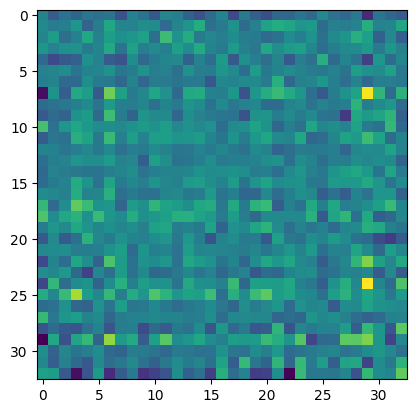

In [ ]:
plt.imshow((model.perm_1 @ b[0,:,:,:].squeeze()  @ model.perm_2).detach())